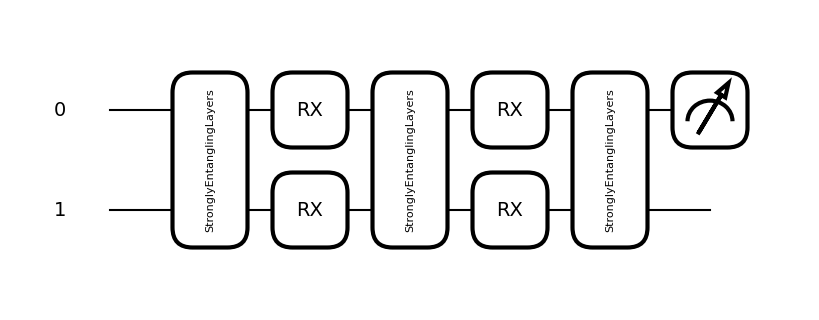

In [113]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import time
import matplotlib.pyplot as plt
from pennylane.templates import StronglyEntanglingLayers

# Hyperparameters remain as before
num_qubits = 2
trainable_block_layers = 2
learning_rate = 0.3
num_iterations = 60
n_points = 60
np.random.seed(42)
scaling = 1
main_device = torch.device("cpu")

# Create a PennyLane device on CPU (to avoid complex number issues on MPS)
dev = qml.device("default.qubit", wires=num_qubits, shots=None)  # default.qubit runs on CPU

# Define your quantum circuit blocks and QNode as before.
def S(weights, x):
    for w in range(num_qubits):
        qml.RX(scaling * 1 * x, wires=w)
        # qml.RX(scaling * weights[w] * x, wires=w)

def W(theta):
    StronglyEntanglingLayers(theta, wires=range(num_qubits))

@qml.qnode(dev, interface="torch", diff_method="backprop")
def parallel_quantum_model(W_weights, S_weights, x=None):
    W(W_weights[0])
    for i in range(trainable_block_layers):
        S(S_weights[i], x)
        W(W_weights[i+1])
    return qml.expval(qml.PauliZ(wires=0))

class QPINN(nn.Module):
    def __init__(self):
        super(QPINN, self).__init__()
        self.W_weights = nn.Parameter(0.1 * torch.randn((1 + trainable_block_layers, 2, num_qubits, 3), dtype=torch.float32))
        # self.S_weights = nn.Parameter(torch.stack([torch.arange(1, num_qubits + 1, dtype=torch.float32) for _ in range(trainable_block_layers)]))
        self.S_weights = nn.Parameter(0.1 * torch.randn((trainable_block_layers, num_qubits), dtype=torch.float32))
        # self.S_weights.requires_grad = False

    def forward(self, x):
        outputs = []
        for xi in x:
            output = parallel_quantum_model(self.W_weights.to("cpu"), self.S_weights.to("cpu"), xi.to("cpu"))
            output = output.to(torch.float32)
            outputs.append(output.to(device=x.device))
        return torch.stack(outputs)

model = QPINN().to(main_device)
W_weights_cpu = nn.Parameter(0.1 * torch.randn((1 + trainable_block_layers, 2, num_qubits, 3), dtype=torch.float32))
S_weights = nn.Parameter(0.1 * torch.randn((trainable_block_layers, num_qubits), dtype=torch.float32))

drawer = qml.draw_mpl(parallel_quantum_model)
fig = drawer(W_weights_cpu, S_weights, 0.1)

Training started...
Iteration 10/60, Total Loss: 0.683448, PDE Loss: 0.680823, Boundary Loss: 0.002626
Iteration 20/60, Total Loss: 0.181913, PDE Loss: 0.076346, Boundary Loss: 0.105567
Iteration 30/60, Total Loss: 0.042001, PDE Loss: 0.031737, Boundary Loss: 0.010265
Iteration 40/60, Total Loss: 0.014200, PDE Loss: 0.013996, Boundary Loss: 0.000204
Iteration 50/60, Total Loss: 0.010128, PDE Loss: 0.009920, Boundary Loss: 0.000208
Iteration 60/60, Total Loss: 0.004155, PDE Loss: 0.003507, Boundary Loss: 0.000648
Training finished.
Elapsed time: 78.0918 seconds


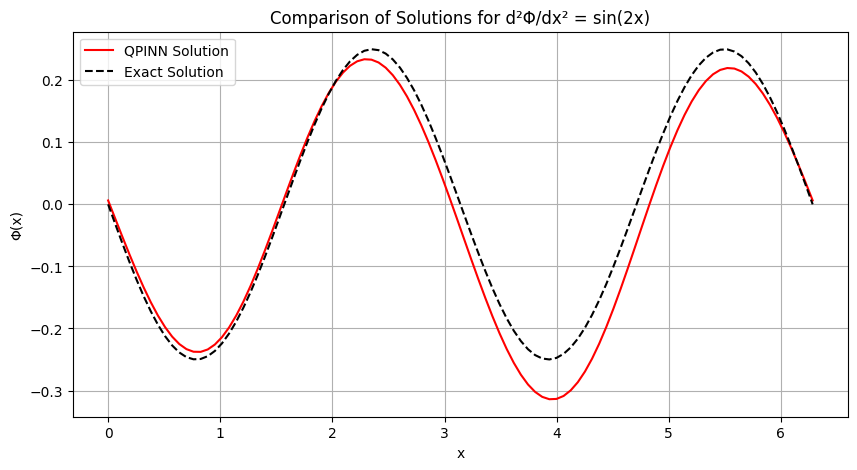

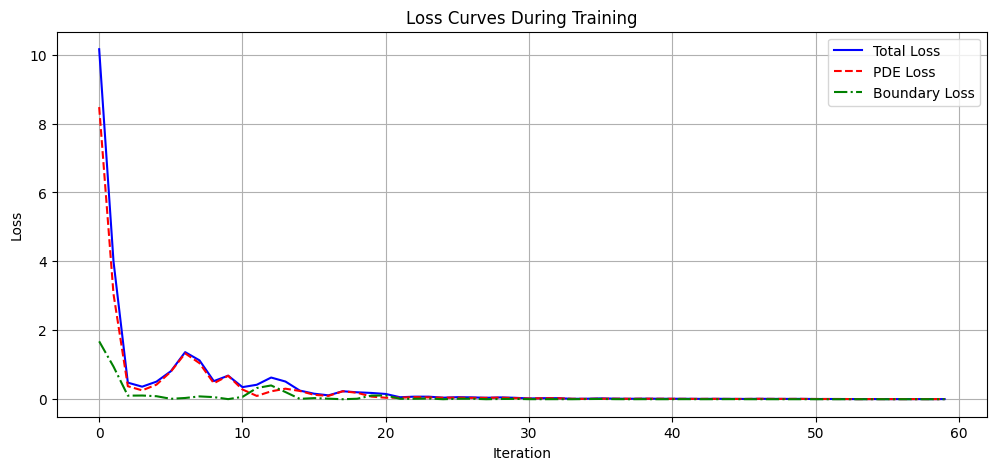

In [114]:
# ----------------------------------------------------------
# Construct the physics-informed loss function (PDE residual and boundary conditions)
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Compute the PDE residual:
        d²Φ/dx² - sin(2x) = 0
    Use PyTorch’s automatic differentiation to compute the first and second derivatives.
    """
    # Compute the first derivative dΦ/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x, grad_outputs=torch.ones_like(phi_pred), create_graph=True
    )[0]
    # Compute the second derivative d²Φ/dx²
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x, grad_outputs=torch.ones_like(dphi_dx), create_graph=True
    )[0]
    # Define the PDE residual as d²Φ/dx² - sin(2x)
    residual = d2phi_dx2 - torch.sin(2 * x)
    return residual

def loss_function(x):
    """
    Compute the total loss:
      - PDE loss: Mean squared error of the residual
      - Boundary condition loss: Penalty enforcing Φ(0)=0 and Φ(2π)=0
    """
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: Φ(0)=0 and Φ(2π)=0. Ensure these tensors are on the main device.
    bc0 = model(torch.tensor([0.0], dtype=x.dtype, device=main_device))
    bc1 = model(torch.tensor([2 * np.pi], dtype=x.dtype, device=main_device))
    bc_loss = torch.mean(bc0**2) + torch.mean(bc1**2)

    total_loss = pde_loss + bc_loss  # You can weigh the boundary loss term if needed.
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Model training
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Create training data on the main device.
x_train = torch.linspace(0, 2 * np.pi, n_points, dtype=torch.float32, device=main_device)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

start_time = time.time()
print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, " +
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

end_time = time.time()
print("Training finished.")
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

# ----------------------------------------------------------
# Model evaluation and comparison of solutions
# ----------------------------------------------------------
# Generate evaluation grid on the main classical device.
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32, device=main_device)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Exact solution:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the comparison between QPINN solution and the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = sin(2x)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves during training
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
